<a href="https://colab.research.google.com/github/hieubkset/Colab-Notebooks/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression**

Một ví dụ về bài toán Regression trên tập dữ liệu [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset.

Mục tiêu:

+ Tìm hiểu các bước thực hiện một bài toán regression đơn giản.
+ Học cách chuẩn bị dữ liệu bằng pandas.
+ Ôn tập cách vẽ learning curve.
+ Làm quen với kỹ thuật early stopping để tránh overfitting.



## **Giới thiệu Auto MPG dataset**

Chúng ta sẽ sử dụng [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset để build một model dự đoán độ hiệu quả sử dụng nhiên liệu của các mẫu xe hơi cuối thập niên 70 và đầu thập niên 80. 

Bộ dữ liệu này gồm 398 example, mỗi example là một hàng bao gồm các trường thông tin sau đây: 

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

Trong đó, **mpg** là viết tắt của mile per gallon, tức số dặm đi được cho một gallon (khoảng 4,5 lít) xăng/dầu. Đó chính là đại lượng chúng ta sẽ dự đoán hay **mpg** chính là label.

## **Chương trình**

### **1. Khai báo thư viện**

Seaborn là một thư viện dùng để visualize dữ liệu, nó được xây dựng dựa trên các API của matplotlib. 

Pandas được dùng để xử lý data từ *Auto MPG* được lưu dưới dạng các hàng và cột. Mỗi hàng là một example, một cột là một trường thông tin.

In [0]:
!pip install seaborn

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

print("Version: ", tf.__version__)

### 2. Chuẩn bị data

**Download dataset**

In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

**Đọc dữ liệu sử dụng pandas**

In [0]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names, 
                          na_values="?", comment="\t",
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


**Loại bỏ các example thiếu trường thông tin**

---



In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

**Chuẩn dữ liệu dưới dạng category sang one-hot vector**

In [0]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3:'Japan'})

In [0]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


**Phân chia dữ liệu cho train và test***

80% dùng cho training và 20% còn lại cho testing

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

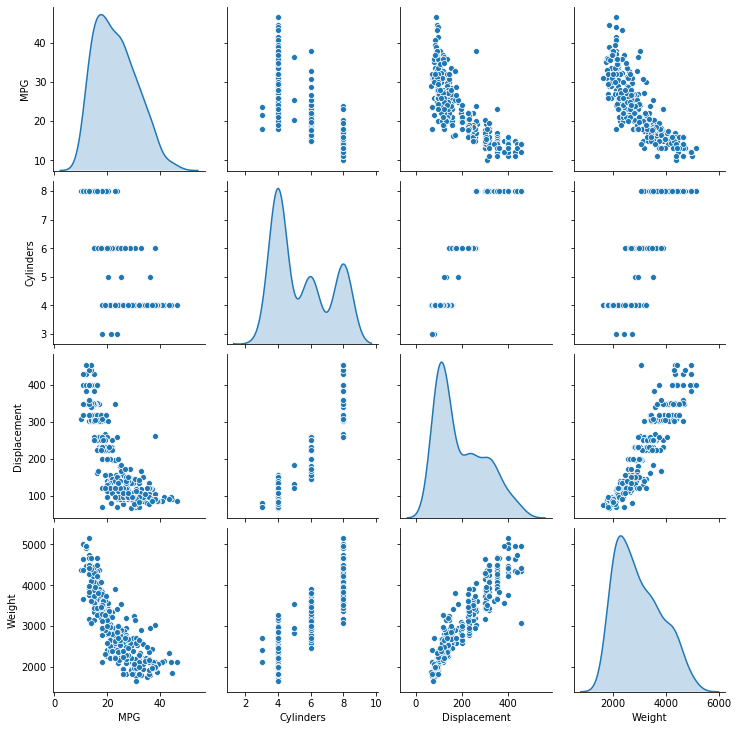

In [0]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Tách label ra khỏi example

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

**Chuẩn hóa dữ liệu đầu vào**

Từ bảng thống kế ở trên, ta thấy các trường dữ liệu có phạm vi khác nhau. Điều này khiến model khó học hơn và phụ thuộc vào đơn vị của dữ liệu.

Ta sẽ tiến hành chuẩn hóa dữ liệu đầu vào sao cho tất cả các trường đều có mean=0 và std=1.0

In [0]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### **3. Build model**

Chúng ta sẽ sử dụng một NN đơn giản như các bài trước. Tuy nhiên, sử dụng RMSprop thay vì Adam optimizer, và sử dụng **mean squared error** cho bài toán regression.

In [0]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### **4. Tiến hành training**

Train model trong 1000 epoch, sử dụng 20% training data cho validation.

In [0]:
history = model.fit(
    normed_train_data, train_labels,
    epochs=1000, validation_split=0.2
)

### **5.Vẽ learning curve**

In [0]:
history_dict = history.history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.560891,1.053051,2.560891,9.839380,2.505887,9.839380,995
996,2.613494,1.033379,2.613494,8.196336,2.143157,8.196336,996
997,2.673161,1.047268,2.673161,8.247517,2.166201,8.247518,997
998,2.569627,1.047698,2.569627,8.842137,2.321381,8.842137,998
999,2.619892,1.068343,2.619893,9.070758,2.392311,9.070758,999


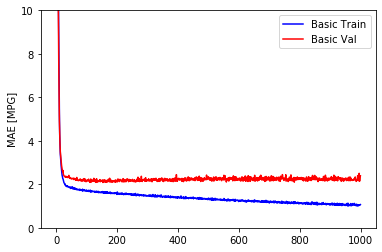

In [0]:
plt.figure()
plt.plot(history.epoch, history_dict['mae'], 'b-', label='Basic Train')
plt.plot(history.epoch, history_dict['val_mae'], 'r-', label='Basic Val')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.legend()
plt.show()

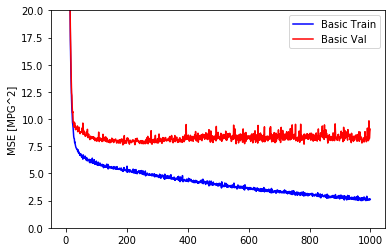

In [0]:
plt.figure()
plt.plot(history.epoch, history_dict['mse'], 'b-', label='Basic Train')
plt.plot(history.epoch, history_dict['val_mse'], 'r-', label='Basic Val')
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')
plt.legend()
plt.show()

Nhìn vào learning curve chúng ta thấy validation error không giảm sau khoảng 100 epoch. Tiếp tục training sau 100 epoch dẫn tới model bị overfitting. Chúng ta sẽ sử dụng **early stopping** để giải quyết vấn đề này.

### **6. Early Stopping**

**Early Stopping** callback sẽ được gọi tại cuối mỗi epoch, nó sẽ kiểm tra một điều kiện. Nếu điều kiện đó không thỏa mãn sẽ kết thúc training.

Ví dụ dưới đây, chúng ta sẽ kết thúc training nếu validation loss không giảm đi 10 sau mỗi epoch.

In [0]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                          epochs=1000, validation_split=0.2, 
                          callbacks=[early_stop])

**Vẽ learning curve sau khi áp dụng Early Stopping**

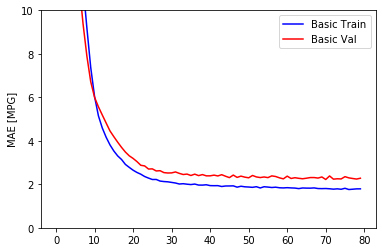

In [0]:
history_dict = early_history.history
plt.figure()
plt.plot(range(len(history_dict['mae'])), history_dict['mae'], 'b-', label='Basic Train')
plt.plot(range(len(history_dict['val_mae'])), history_dict['val_mae'], 'r-', label='Basic Val')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.legend()
plt.show()

### **7. Testing**

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print('Testing set MAE: {:5.2f} MPG'.format(mae))

78/78 - 0s - loss: 6.3623 - mae: 1.9760 - mse: 6.3623
Testing set MAE:  1.98 MPG


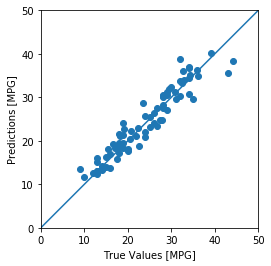

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

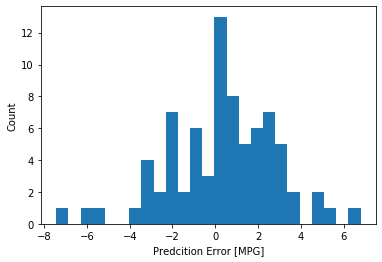

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Predcition Error [MPG]")
plt.ylabel("Count")
plt.show()